A new test of the correction functions, but this time with a properly splittable Hamiltonian that should yield interesting differences between RK4 and Euler correction steps.

In [1]:
from orbitflows import HamiltonianMappingModel, generate_sho_orbits
import matplotlib.pyplot as plt
import numpy as np
import torch
from orbitflows import H, H_sho, actionAngleHarmonic, actionAngleHarmonicInverse
from orbitflows.integrate import eulerstep, rungekutta4
from time import time
from functools import partial
from tqdm import tqdm

In [2]:
def sho_potential_frac(x, alpha, omega):
    return alpha * (0.5*(omega*x)**2)

def H_partial(ps, coeff, omega):
    return coeff * H_sho(ps, omega)

In [3]:
# check my analytic solution for H_sho * alpha
def ps_integration(ps, steps, dt, H, stepfunc=eulerstep):
    ps_list = torch.zeros((steps + 1, 2))#, len(ps), 2))
    ps_list[0] = ps
    for i in range(steps):
        ps = stepfunc(ps, dt, H)
        ps_list[i+1] = ps
    return ps_list

In [4]:
ps = torch.tensor([1.0, 0.0], requires_grad=True)

In [5]:
def analytic_solution(ps, t_list, alpha, omega):
    q0 = ps[..., 0]
    p0 = ps[..., 1]
    
    A = torch.sqrt(q0**2 + (p0/(omega))**2)
    phase = - torch.atan2(p0 / omega, q0)

    q = A * torch.cos(omega * t_list * alpha + phase)
    p = - A * omega * torch.sin(omega * t_list * alpha + phase)
    ps_list = torch.stack((q, p), dim=-1)
    return ps_list

In [65]:
H_sho(analytic_solution(ps, torch.linspace(0, 10, 100), 1.0, 1.0))

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000], grad_fn=<AddBackward0>)

In [6]:
# alpha = 0.5
# ps_int = ps_integration(ps, 10, 0.1, H=partial(H_partial, coeff=alpha, omega=1.0), stepfunc=rungekutta4)
# ps_sho = ps_integration(ps, 10, 0.1, H=partial(H_sho, omega=1.0), stepfunc=rungekutta4)
# t_list = torch.linspace(0, 10*0.1, 10 + 1)
# ps_analytic = analytic_solution(ps, t_list, alpha=alpha, omega=1.0)

# plt.plot(ps_int[:, 0].detach().numpy(), ps_int[:, 1].detach().numpy(), label='integrated', alpha=0.5)
# plt.plot(ps_sho[:, 0].detach().numpy(), ps_sho[:, 1].detach().numpy(), label='SHO', alpha=0.5)
# plt.plot(ps_analytic[:, 0].detach().numpy(), ps_analytic[:, 1].detach().numpy(), label='analytic', alpha=0.5)
# plt.legend()

# plt.axis('equal')

In [73]:
def integrate(ps, steps, t_end, alpha, hamiltonian_error, correction=eulerstep):
    '''Routine to integrate orbits exactly in phase space space and update frequencies regularly, with euler step correction

    Parameters
    ----------
    aa : torch.tensor
        initial action-angle variables

    steps : int
        number of steps in action-angle space between frequency updates

    t_end : float
        end time of the integration
    
    correction : callable
        correction function to be used in the integration process.
        Should take the phase-space coordinates, the time step, and the hamiltonian_tilde
        function as arguments.
        The function should return new phase-space coordinates of the same shape as the input.

    hamiltonian_tilde : callable
        Assumption for the correct Hamiltonian as a function of action-angle variables.
        Only arguments should be model and aa, so it's recommended to use a partial function or
        redefine the function such that this is the case.
    
    Returns
    -------
    torch.tensor
        action-angle variables as a function of time
    
    '''

    
    ps_list = torch.zeros((steps, 2))#, len(ps), 2))
    delta_t = t_end / steps

    for i, t in enumerate(tqdm(torch.linspace(0, t_end, steps))):
        # evolve in phase space
        ps_half = analytic_solution(ps, delta_t/2, alpha=alpha, omega=1.0)

        # compute Hamiltonian error
        ps_half_corrected = correction(ps_half, delta_t, hamiltonian_error)


        ps_full = ps_half = analytic_solution(ps_half_corrected, delta_t/2, alpha=alpha, omega=1.0)


        ps_list[i] = ps_full
        ps = ps_full.clone()
        #print(theta0, J0)
    return ps_list

In [74]:
ps_null_euler = integrate(ps0.to(torch.float64), steps=100, t_end=10, alpha=1, hamiltonian_error=partial(H_partial, coeff=0, omega=omega), correction=eulerstep)
ps_null_rk4 = integrate(ps0.to(torch.float64), 100, 10, 1, hamiltonian_error=partial(H_partial, coeff=0, omega=omega), correction=rungekutta4)

100%|██████████| 100/100 [00:00<00:00, 899.02it/s]


In [85]:
alpha = 0.1
omega = 1.0
# model = HamiltonianMappingModel(targetPotential=partial(sho_potential_frac, alpha=alpha, omega=omega), input_dim=2, hidden_dim=128, num_layers=64)
#model.train(ps_guess, 0) # try to make it not train at all

In [86]:
# def h_tilde(ps, alpha, omega):
#     return (2 * alpha - 1) * H_sho(ps, omega=omega)

In [87]:
ps0 = torch.tensor([1.0, 0.0], requires_grad=True)
ps_euler = integrate(ps0.to(torch.float64), 100, 10, alpha, hamiltonian_error=partial(H_partial, coeff=(1 - alpha), omega=omega), correction=eulerstep)
ps_rk4 = integrate(ps0.to(torch.float64), 100, 10, alpha, hamiltonian_error=partial(H_partial, coeff=(1 - alpha), omega=omega), correction=rungekutta4)
ps_null_euler = integrate(ps0.to(torch.float64), steps=100, t_end=10, alpha=1, hamiltonian_error=partial(H_partial, coeff=0, omega=omega), correction=eulerstep)
ps_null_rk4 = integrate(ps0.to(torch.float64), 100, 10, 1, hamiltonian_error=partial(H_partial, coeff=0, omega=omega), correction=rungekutta4)


100%|██████████| 100/100 [00:00<00:00, 909.46it/s]


Text(0, 0.5, 'p')

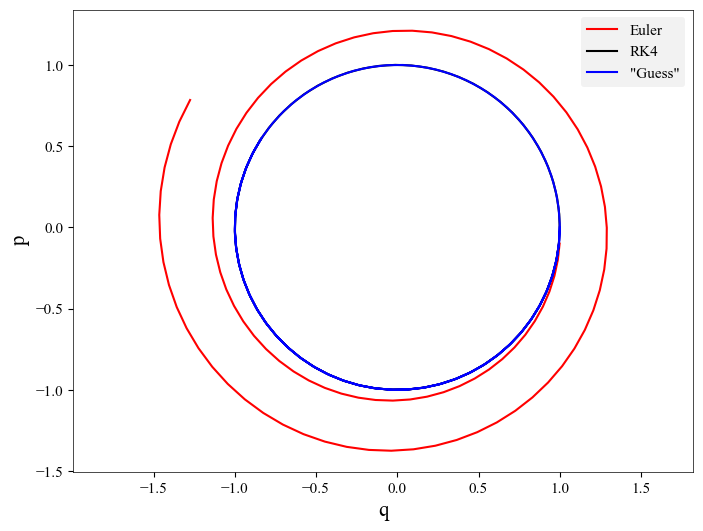

In [91]:
plt.plot(ps_euler[:, 0].detach().numpy(), ps_euler[:, 1].detach().numpy(), label='Euler', alpha=1, c='r')
plt.plot(ps_rk4[:, 0].detach().numpy(), ps_rk4[:, 1].detach().numpy(), label='RK4', alpha=1, c='k')

t_ = torch.linspace(0, 10, 100)
ps_ana = analytic_solution(ps0.to(torch.float64), t_, alpha=1, omega=1.0)
plt.plot(ps_ana[:, 0].detach().numpy(),
         ps_ana[:, 1].detach().numpy(), label='"Guess"', alpha=1, c='b')

plt.legend()
plt.axis('equal')
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)

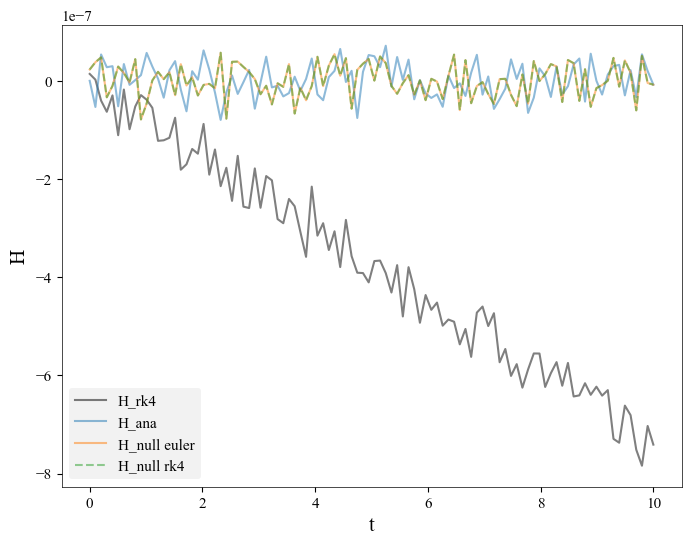

In [104]:
H0 = H_sho(ps0.to(torch.float64), omega=1.0)
#plt.plot(t_, ((H_sho(ps_euler, omega=1.0) - H0)/H0).detach().numpy(), label='H_euler', alpha=0.5)
plt.plot(t_, ((H_sho(ps_rk4.to(torch.float64), omega=1.0) - H0)/H0).detach().numpy(), label='H_rk4', alpha=0.5)
plt.plot(t_, ((H_sho(ps_ana.to(torch.float64), omega=1.0) - H0)/H0).detach().numpy(), label='H_ana', alpha=0.5)
plt.plot(t_, ((H_sho(ps_null_euler.to(torch.float64), omega=1.0) - H0)/H0).detach().numpy(), label='H_null euler', alpha=0.5)
plt.plot(t_, ((H_sho(ps_null_rk4.to(torch.float64), omega=1.0) - H0)/H0).detach().numpy(), label='H_null rk4', alpha=0.5, linestyle='--')
#plt.plot(t_, ((H_sho(ps_euler.to(torch.float64), omega=1.0) - H0)/H0).detach().numpy(), label='H_euler', alpha=0.5)
plt.xlabel('t', fontsize=15)
plt.ylabel('H', fontsize=15)
plt.legend()

In [107]:
alpha_list = torch.linspace(0, 1, 40)
error_list = torch.zeros((len(alpha_list), 2))
H0 = H_sho(ps0.to(torch.float64), omega=1.0)
for i, al in enumerate(alpha_list):
    model = HamiltonianMappingModel(targetPotential=partial(sho_potential_frac, alpha=al, omega=omega), input_dim=2, hidden_dim=128, num_layers=64)
    ps_euler = integrate(ps0.to(torch.float64), 100, 10, al, hamiltonian_error=partial(H_partial, coeff=(1 - al), omega=omega), correction=eulerstep)
    ps_rk4 = integrate(ps0.to(torch.float64), 100, 10, al, hamiltonian_error=partial(H_partial, coeff=(1 - al), omega=omega), correction=rungekutta4)
    error_list[i, 0] = (torch.max(torch.abs(H_sho(ps_euler.to(torch.float64), omega=1.0) - H0))/H0) * 100
    error_list[i, 1] = (torch.max(torch.abs(H_sho(ps_rk4.to(torch.float64), omega=1.0) - H0))/H0)* 100

100%|██████████| 100/100 [00:00<00:00, 909.96it/s]


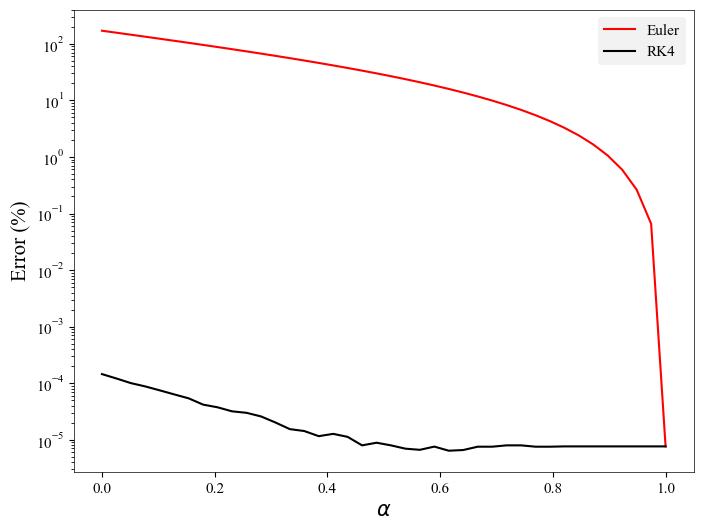

In [113]:
plt.plot(alpha_list.detach().numpy(), error_list[:, 0].detach().numpy(), label='Euler', alpha=1, c='r')
plt.plot(alpha_list.detach().numpy(), error_list[:, 1].detach().numpy(), label='RK4', alpha=1, c='k')
plt.xlabel('$\\alpha$', fontsize=15)
plt.ylabel('Error (%)', fontsize=15)
plt.yscale('log')
#plt.xscale('log')

plt.legend()
plt.show()

In [ ]:
h_error = partial(H_partial, coeff=(1 - alpha), omega=omega)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_32949/1253406774.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)



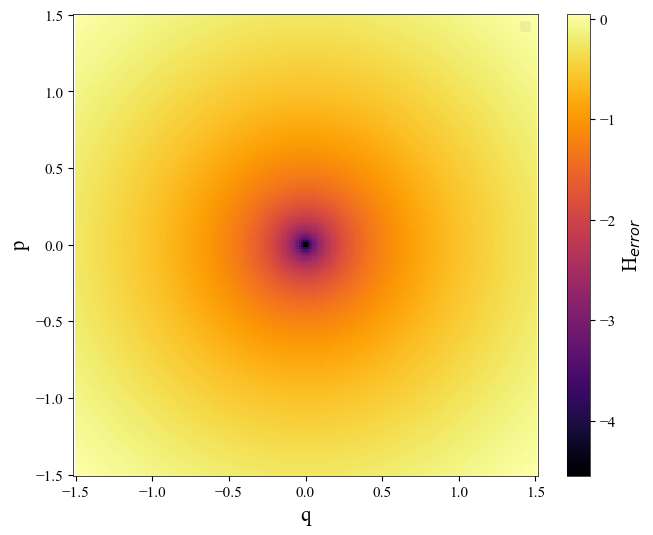

In [ ]:
# Determine the range for q (x) and p (vx) from training data
n_grid_points = 200 # Number of points for each dimension in the grid
grid_minmax = 1.5
x_grid = torch.linspace(-grid_minmax, grid_minmax, n_grid_points)
vx_grid = torch.linspace(-grid_minmax, grid_minmax, n_grid_points)
X, VX = torch.meshgrid(x_grid, vx_grid, indexing='xy')

# Prepare phase-space points for h_error function
# Shape: (n_grid_points*n_grid_points, 2)
ps_grid = torch.stack([X.flatten(), VX.flatten()], dim=1)

# Calculate h_error for each point in the grid
error_values = torch.zeros(ps_grid.shape[0])
# Batch processing if memory is an issue, but for 100x100 it should be fine

with torch.no_grad(): # No need to track gradients for plotting
    error_values = h_error(ps_grid)

# Reshape error_values to the grid shape
error_grid = error_values.reshape(n_grid_points, n_grid_points)

# Plot the colormap
plt.figure(figsize=(7.5, 6))

pcm = plt.pcolormesh(X.numpy(), VX.numpy(), np.log10(np.abs(error_grid.numpy())), cmap='inferno', shading='auto')
plt.colorbar(pcm)
pcm.colorbar.set_label('H$_{error}$', fontsize=15)

plt.legend(fontsize=10)
plt.xlabel('q', fontsize=15)
plt.ylabel('p', fontsize=15)
plt.axis('equal') # Keep aspect ratio for phase space
plt.show()